# Libraries

In [1]:
import sys
net_dir = r"IS_Fall_2022_Net"
sys.path.append(net_dir)

import numpy as np
import torch
from learner import Learner
import evaluator
import utils
import random
import os
import pickle
import matplotlib.pyplot as plt
from itertools import product

#this should seed them globally to reduce variability
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
pass

# IS_Fall_2022_Net
An atlas-based registration network created for my Fall 2022 Independent Study

# Data Preprocessing and Structure
### Preprocessing
This network expects that
- All the training/validation/testing images are affinely registered to the atlas image.
  - And each have a corresponding "rough guess" mesh (Class from the IS_Fall_2022_Net/parser.py)
- The dimension and voxel size is constant in all 3 dimensions, though the actual value is configurable.
- The training/validation/testing/gt images are raw image files written with a byte order of 'F' (Fortran-style order), with a float32/single datatype
- The atlas image has a corresponding mask, mesh, point correspondence mesh, and distance map
  - The image, mask, and distance map should be .nrrd files
  - The mesh is a Mesh class, defined in IS_Fall_2022_Net/parser.py
- All the masks (atlas/gt) are binary masks with black = 0 and white = 255
- All the images are scaled such that the min is around 0 and the max is around 1 (doesn't have to be exact)
  - If there is any "out of bounds" areas that happen due to the affine registration and cropping issues, fill them in with the mean value of the rest of the image
  
### File Structure
This network expects that each training/validation/testing case has a unique patient ID, also called a "keyword". It expects that there's a file where the keywords are listed, in three sections separated by double newlines, for training/validation/testing respectively. For example:

train_keyword1<br>
train_keyword2<br>
train_keyword3<br>

valid_keyword1<br>
valid_keyword2<br>
valid_keyword3<br>

test_keyword1<br>
test_keyword2<br>
test_keyword3<br>

It also expects that there's an image directory, mesh directory, and ground truth directory, with files following a consistent structure. These structures can be defined in the img_template, mesh_template, and gt_template sections of the parameter dictionary.

# Parameter Dictionary

In [2]:
params = {}

params["training_params"] = {}
params["training_params"]["batch_size"] = 5
params["training_params"]["epochs"] = 100
params["training_params"]["dim"] = (64, 64, 64)
params["training_params"]["sz"] = (0.3, 0.3, 0.3)
params["training_params"]["device"] = "cuda"

params["path_params"] = {}
params["path_params"]["keyword_filename"]        = r"D:\Project_Data\DATA\IAC\info\keywords.txt" #a list of all patient IDs, separated into training, validation, and testing chunks by double newlines
params["path_params"]["progress_dir"]            = "output"

#these are the paths for the data, where %s will get replaced with the patient ID
params["path_params"]["img_dir"]                 = r"D:\Project_Data\DATA\IAC\img_mean" #where the images are
params["path_params"]["mesh_dir"]                = r"D:\Project_Data\DATA\IAC\meshes" #where the meshes are
params["path_params"]["gt_dir"]                  = r"D:\Project_Data\DATA\IAC\gt" #where the ground truth is
params["path_params"]["img_template"]            = "%s_scaled_mean_filled_img.im" #how the image filenames are formatted in the image dir
params["path_params"]["mesh_template"]           = "%s_standardized_mesh.mesh" #how the oob filenames are formatted
params["path_params"]["gt_template"]             = "%s_standardized_msk.im" #how the gt filenames are formatted

#atlas
params["path_params"]["atlas_im_filename"]       = r"D:\Project_Data\DATA\IAC\atlas\alt_personal_comp\atlas_scaled_mean_filled_img.nrrd" #the atlas CT image
params["path_params"]["atlas_mesh_filename"]     = r"D:\Project_Data\DATA\IAC\atlas\alt_personal_comp\atlas_standardized_mesh.mesh" #the atlas mesh
params["path_params"]["p2p_atlas_mesh_filename"] = r"D:\Project_Data\DATA\IAC\atlas\p2p_atlas_mesh.mesh" #the atlas p2p mesh
params["path_params"]["atlas_mask_filename"]     = r"D:\Project_Data\DATA\IAC\atlas\alt_personal_comp\atlas_standardized_msk.nrrd" #the atlas mask
params["path_params"]["ms_atlas_filename"]       = r"D:\Project_Data\DATA\IAC\atlas\alt_personal_comp\levelset_atlas_mask.nrrd" #if using a modified atlas mask for the mumford shah term, put the filename here. else make an empty string
params["path_params"]["atlas_dist_filename"]     = r"D:\Project_Data\DATA\IAC\atlas\alt_personal_comp\atlas_standardized_dst.nrrd" #a distance transform of the atlas in mm

#losses
params["losses"] = {}
params["losses"]["cross_correlation"] = {"filename":"losses.cross_correlation_loss", "weight": 1.5}
params["losses"]["weighted_gradient"] = {"filename":"losses.weighted_gradient_loss", "weight": 1.0}
params["losses"]["ranged_levelset"]   = {"filename":"losses.ranged_levelset_loss"  , "weight": 2.0}
params["losses"]["mesh_distance"]     = {"filename":"losses.mesh_distance_loss"    , "weight": 35.0}

#debug
params["debug_params"] = {}
params["debug_params"]["verbose"] = False

#for evaluating the traditional method
compare_to_traditional_method = True
mask_dir           = r"D:\Project_Data\DATA\IAC\msk"
mask_name_template = "%s_standardized_msk.im"
mask_template      = os.path.join(mask_dir, mask_name_template)

# Use the Learner
**The "learner" is an object which handles all of the network's training, testing, etc. The goal is to separate the "input" and "processing" as much as possible, for maximal versatility**

Loading parameters...
Making destination directories...
Loading global values...
Loading model...
Making dataloaders...
Starting training...
Epoch 1/100:
Epoch:  1 , train: 0.6556850217711863 , valid: 0.49854499101638794
Saving model...
	completed in 47.95415663719177 seconds
Epoch 2/100:
Epoch:  2 , train: 0.5463263304549778 , valid: 0.4859340116381645
Saving model...
	completed in 47.734697103500366 seconds
Epoch 3/100:
Epoch:  3 , train: 0.5198089562577519 , valid: 0.4528011195361614
Saving model...
	completed in 47.82212042808533 seconds
Epoch 4/100:
Epoch:  4 , train: 0.47946007365123555 , valid: 0.4099145904183388
Saving model...
	completed in 48.05831289291382 seconds
Epoch 5/100:
Epoch:  5 , train: 0.44035334825307704 , valid: 0.37683497555553913
Saving model...
	completed in 48.01310873031616 seconds
Epoch 6/100:
Epoch:  6 , train: 0.3981761582338789 , valid: 0.3439007606357336
Saving model...
	completed in 48.72683930397034 seconds
Epoch 7/100:
Epoch:  7 , train: 0.3594638793

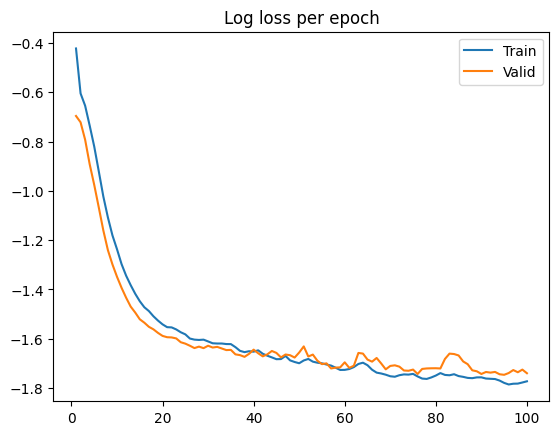

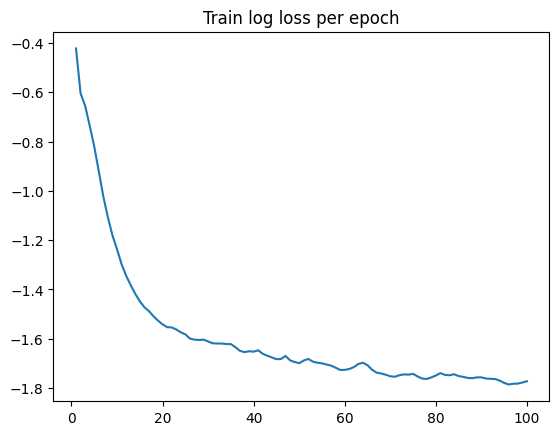

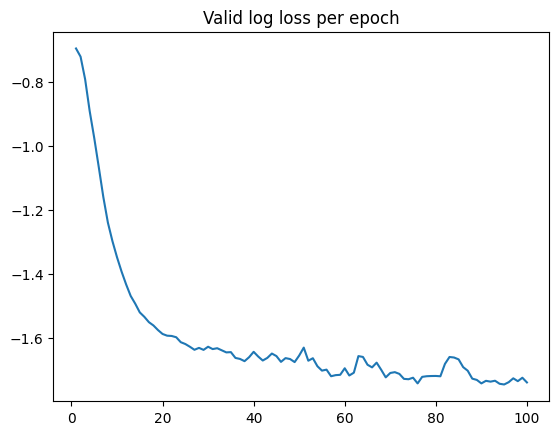

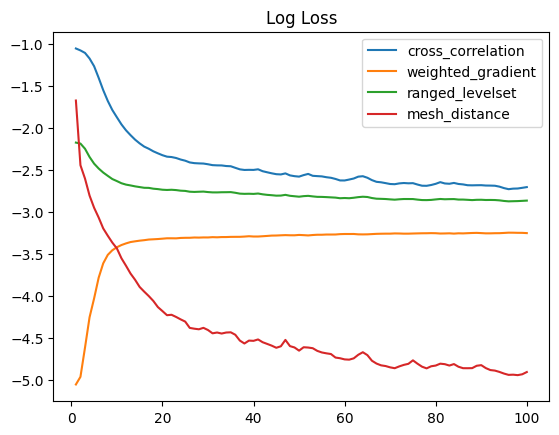

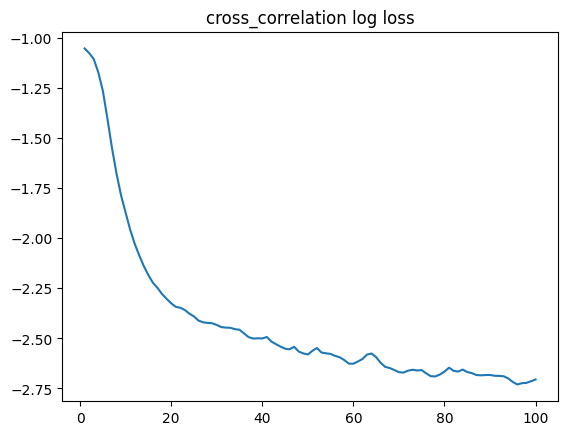

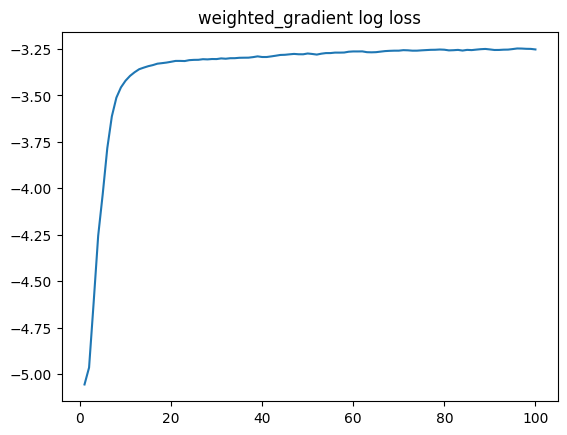

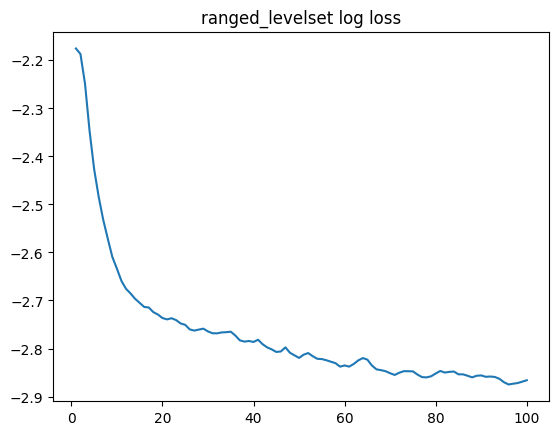

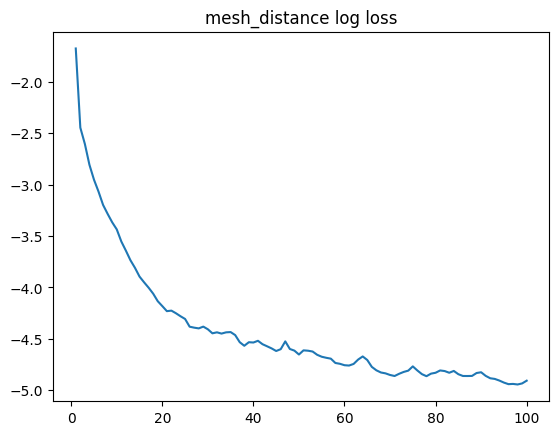

Testing batch 1 of 17 | Loss: 0.1552862673997879
Testing batch 2 of 17 | Loss: 0.13518255949020386
Testing batch 3 of 17 | Loss: 0.21029409766197205
Testing batch 4 of 17 | Loss: 0.1756298691034317
Testing batch 5 of 17 | Loss: 0.1523085981607437
Testing batch 6 of 17 | Loss: 0.1359180361032486
Testing batch 7 of 17 | Loss: 0.15261872112751007
Testing batch 8 of 17 | Loss: 0.17764593660831451
Testing batch 9 of 17 | Loss: 0.1529082953929901
Testing batch 10 of 17 | Loss: 0.15440991520881653
Testing batch 11 of 17 | Loss: 0.15699616074562073
Testing batch 12 of 17 | Loss: 0.13558626174926758
Testing batch 13 of 17 | Loss: 0.12519028782844543
Testing batch 14 of 17 | Loss: 0.16729730367660522
Testing batch 15 of 17 | Loss: 0.15206485986709595
Testing batch 16 of 17 | Loss: 0.15632672607898712
Testing batch 17 of 17 | Loss: 0.31093138456344604
Testing valid batch 1 of 16 | Loss: 0.16332921385765076
Testing valid batch 2 of 16 | Loss: 0.16802726686000824
Testing valid batch 3 of 16 | Loss:

In [3]:
lrnr = Learner(params, "ABCNet-Example", verbose_learner = True)
lrnr.train()
lrnr.export()
lrnr.evaluate()

# Evaluate the Traditional Method

In [4]:
if compare_to_traditional_method:
    keywords = lrnr.test_keywords
    dim = lrnr.dim.numpy().astype(int)
    sz = lrnr.sz.numpy()
    asm_dice = []
    asm_dist = []
    for keyword in keywords:
        #load traditional_mesh
        asm_mesh_fname = lrnr.mesh_template.replace("%s", keyword)
        asm_verts = utils.read_mesh_verts(asm_mesh_fname)
        #load ground truth mask
        gt_fname = lrnr.gt_template.replace("%s", keyword)
        gt_mask = utils.read_raw_volume_file(gt_fname, lrnr.dim, np.uint8)
        #eval dist
        dist_95 = evaluator.comp_mesh_to_im(asm_verts, gt_mask, sz[0], dim, sz[0], dim)[1]
        asm_dist.append(dist_95)
        #load traditional mask
        asm_mask_fname = mask_template.replace("%s", keyword)
        asm_mask = utils.read_raw_volume_file(asm_mask_fname, lrnr.dim, np.uint8)
        dice_score = evaluator.dice(asm_mask >= 127, gt_mask >= 127)
        asm_dice.append(dice_score)

# Plot the results

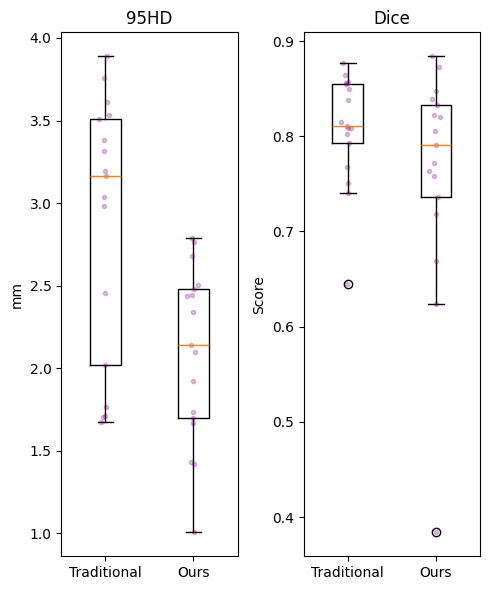

In [9]:
with open(os.path.join(lrnr.progress_dir, "results.pkl"), "rb") as file:
    results = pickle.load(file)

def noble_boxplot(D):
    bp = plt.boxplot(D, widths=0.35)
    sf = .1 * (1 - np.exp(-np.shape(D)[1] / 4))
    d_bin = np.zeros(np.shape(D)[0], dtype=int)
    
    for i in range(np.shape(D)[1]):
        h, x = np.histogram(D[:, i], bins=10)
        h = h / np.amax(h) if np.amax(h) > 0 else h
        for j in range(np.shape(D)[0]):
            bin = np.nonzero(D[j, i] < x)
            if np.size(bin) > 0:
                d_bin[j] = bin[0][0] - 1
            else:
                d_bin[j] = np.size(x) - 2

        dx = np.random.default_rng(0).normal(size=np.shape(D)[0]) * sf * h[d_bin]
        msk = np.abs(dx) > sf * 2
        dx[msk] = 2 * sf * dx[msk] / np.abs(dx[msk])

        plt.plot(dx + i + 1, D[:, i], '.', color="purple", alpha=.25)
        
if not compare_to_traditional_method:
    plt.figure(figsize = (4, 6))
    plt.subplot(121)
    plt.title("95HD")
    noble_boxplot(np.expand_dims(results['test']['dist_95s'], axis = 1))
    plt.ylabel("mm")
    plt.gca().axes.get_xaxis().set_visible(False)

    plt.subplot(122)
    plt.title("Dice")
    noble_boxplot(np.expand_dims(results['test']['dice_scores'], axis = 1))
    plt.ylabel("Score")
    plt.gca().axes.get_xaxis().set_visible(False)

    plt.tight_layout()
    plt.show()
else:
    plt.figure(figsize = (5, 6))
    big_dist = np.array([asm_dist, results['test']['dist_95s']]).T
    big_dice = np.array([asm_dice, results['test']['dice_scores']]).T
    labels = ["Traditional", "Ours"]
    plt.subplot(121)
    plt.title("95HD")
    noble_boxplot(big_dist)
    plt.ylabel("mm")
    plt.xticks(ticks=range(1, len(labels)+1), labels=labels)

    plt.subplot(122)
    plt.title("Dice")
    noble_boxplot(big_dice)
    plt.ylabel("Score")
    plt.xticks(ticks=range(1, len(labels)+1), labels=labels)

    plt.tight_layout()
    plt.show()

# Setup losses for an ablation study
Set up an array of losses to iterate over

In [6]:
#losses
loss_dict = {}
loss_dict["cross_correlation"] = {"filename":"losses.cross_correlation_loss", "weights": [1.5]}
loss_dict["weighted_gradient"] = {"filename":"losses.weighted_gradient_loss", "weights": [1.0, 0]}
loss_dict["ranged_levelset"]   = {"filename":"losses.ranged_levelset_loss"  , "weights": [2.0, 0]}
loss_dict["mesh_distance"]     = {"filename":"losses.mesh_distance_loss"    , "weights": [35.0, 0]}

keys = list(loss_dict.keys())
weight_lists = [loss_dict[key]["weights"] for key in keys]
combinations = list(product(*weight_lists))
trials = [{"losses":{key: value for key, value in zip(keys, combo)}} for combo in combinations]
for trial in trials:
    label = ""
    short = ""
    for loss_name, weight in trial["losses"].items():
        if weight != 0:
            label = label + loss_name + "_" + str(float(weight)) + "_"
            short = short + ''.join([word[0].upper() for word in loss_name.split("_")]) + ": " + str(float(weight)) + "\n"
    label = label[:-1]
    short = short[:-1]
    trial['label'] = label
    trial['short'] = short

In [7]:
sweep_dir = "sweep_output"
params["losses"] = {}
for trial in trials:
    for loss_name, weight in trial['losses'].items():
        params["losses"][loss_name] = {"filename":loss_dict[loss_name]["filename"], "weight": weight}
    params["path_params"]["progress_dir"] = os.path.join(sweep_dir, trial['label'])
    print("Running %s..."%trial['label'])
    lrnr = Learner(params, "IS_Fall_2022_Net-Example-"+trial["label"], verbose_learner = False)
    lrnr.train()
    lrnr.export()
    lrnr.evaluate()

Running cross_correlation_1.5_weighted_gradient_1.0_ranged_levelset_2.0_mesh_distance_35.0...
Running cross_correlation_1.5_weighted_gradient_1.0_ranged_levelset_2.0...
Running cross_correlation_1.5_weighted_gradient_1.0_mesh_distance_35.0...
Running cross_correlation_1.5_weighted_gradient_1.0...
Running cross_correlation_1.5_ranged_levelset_2.0_mesh_distance_35.0...
Running cross_correlation_1.5_ranged_levelset_2.0...
Running cross_correlation_1.5_mesh_distance_35.0...
Running cross_correlation_1.5...


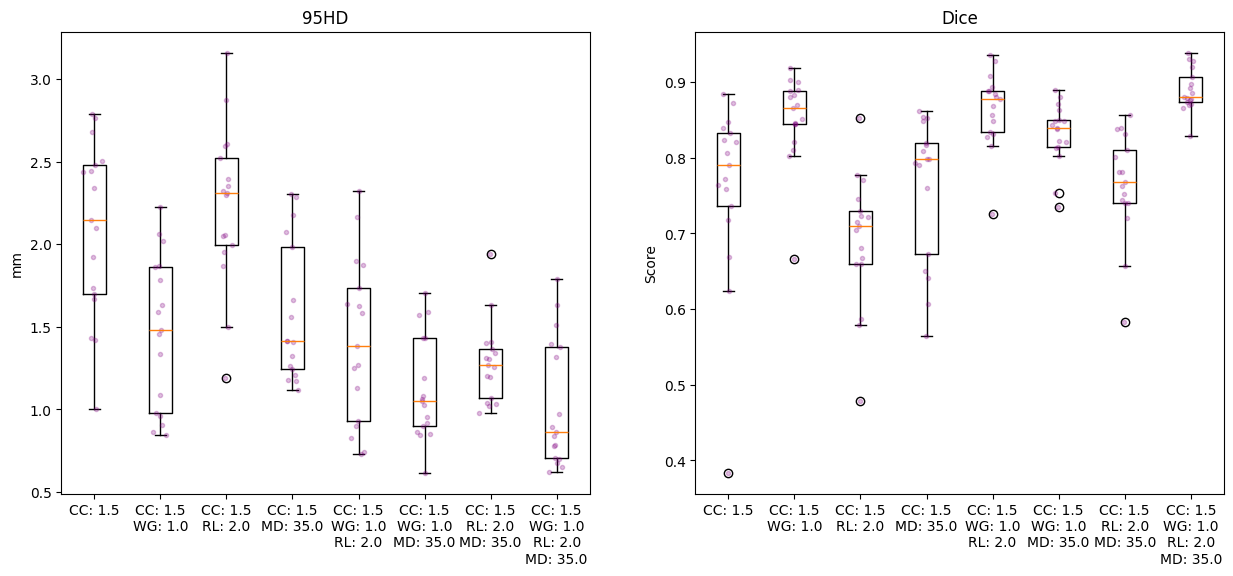

In [8]:
dice = []
dist = []
labels = []

for trial in trials:
    with open(os.path.join(sweep_dir, trial['label'], "results.pkl"), "rb") as file:
        results = pickle.load(file)
    dice.append(results['test']['dice_scores'])
    dist.append(results['test']['dist_95s'])
    labels.append(trial['short'])
    
dice = np.array(dice).T
dist = np.array(dist).T

sorted_indices = np.argsort([len(label) for label in labels])
labels = [labels[i] for i in sorted_indices]
dice = dice[:, sorted_indices]
dist = dist[:, sorted_indices]

plt.figure(figsize = (15, 6))
plt.subplot(121)
plt.title("95HD")
noble_boxplot(dist)
plt.ylabel("mm")
plt.xticks(ticks=range(1, len(labels)+1), labels=labels)

plt.subplot(122)
plt.title("Dice")
noble_boxplot(dice)
plt.ylabel("Score")
plt.xticks(ticks=range(1, len(labels)+1), labels=labels)

plt.show()

These results may differ from the results shown in the paper due to the fact that
- I was unable to find the original runs for this Independent Study
- We've improved our ground truth dataset since this study was original performed, and used the new data for this notebook
- PyTorch has inherent issues with repeatability, especially for ablation studies. In future work, I have come up with strategies to limit this, but that was after this study.